# Appendix B
# Polynomial approximations of log and sigmoid functions

As we use the CKKS encryption scheme, computations on ciphertext are limited. Only additions and multiplications are allowed, and furthermore, the few multiplication we perform, the better. 

So as to use 'only' 16384 as poly_modulus_degree (which is already huge) and willing to be able to perform a entiere epoch without refreshing the weight, we limited ourself to 3 degree polynoms to approximate log and sigmoid.

In [4]:
import numpy as np

from scipy.optimize import minimize

import matplotlib.pyplot as plt

### Sigmoid approximation

We will use logistic regression, so we need an approximation of the sigmoid function $$ sigmoid(x) = \frac{1}{1+e^{-x}}$$
For polynomial approximation the first idea is the 3-d taylor approximation: 
$$ sigmoid(x) = \frac{1}{2} + \frac{x}{4} - \frac{11}{48}x^3$$

We will see that, even if this approximation is really good when x reach to 0, it is quickly really bad when x goes away from 0.

But what we really need is an good approximation on a range of values. The solution suggested by [introduireref] is a minmax approximation : 
$$ sigmoid(x) = 0.5 + 0.197x - 0.004x^3$$

We implemeted both solutions make comparison.

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def approx_MM_sig(x):
    return -0.004 * np.power(x,3) + 0.197*x + 0.5
def approx_DL_sig(x):
    return 0.5 + x *(1/4) - np.power(x,3) * (11/48) 

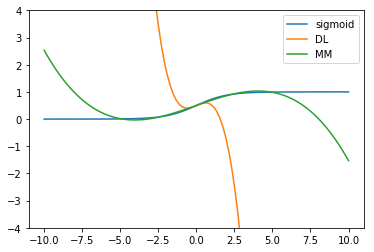

In [7]:
X=np.linspace(-10,10,100)
plt.plot(X, sigmoid(X), label ="sigmoid")
plt.plot(X, approx_DL_sig(X), label="DL")
plt.plot(X, approx_MM_sig(X), label="MM")
#plt.plot(X, activation(X), label="acti")
plt.legend(loc="best")
plt.ylim((-4,4))
plt.show()

Indeed the minmax approximation looks really better than the taylor's one. 
It is important to denote that the approximation is relevant only if $ -5 \leq \theta^TX \leq  5$.
Outside of this intervall, the predictions, thus the gradient values will explode, making our gradient descent diverges. Therefore, it is really important to both initialize our weight to small values (lower than one) and to normalize all the data. In addition, to keep the weight to grown, we impose l2-regularisation on our training.  

## Log approximation

For logistic regression, we use the cross entropy loss. In order to allow Alice to compute this loss while training, we need to provide a polynomial approximation of the log. Here, as the log is used only on prediction, which are supposed to be between 0 and 1, we seek a good approxmiation of the log, in the range 0, 1.

We will then use an optimization algorithm, to minimize the error between the log and our polynomial between 0 and 1. The error will be computed as the l2 norm of the difference between the log evaluation and the polynomial evalution of an set of points which are uniformaly distributed between 0 and 1. 
We minimize the error by adjusting the 4d vector of the polynom coefficients. 

In [18]:
def forward(X,theta):
    res = 0
    for i in range(len(theta)):
        res += theta[i] * np.power(X,i) 
    return res

def loss(theta):
    data=np.linspace(0.01,1,100)
    pred = forward(data,theta)
    return np.linalg.norm(pred-np.log(data))

In [19]:
theta_init = [1,1,1,1]

In [20]:
theta = minimize(loss, theta_init)

In [23]:
theta.x

array([ -3.69404917,  13.3090831 , -19.06855662,   9.63447479])

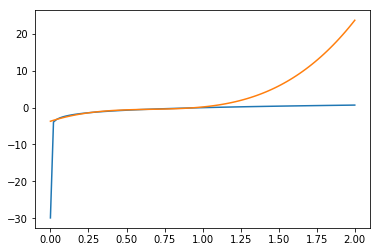

In [22]:
local_X = np.linspace(0.0000000000001, 2,100)
plt.plot(local_X,np.log(local_X))
plt.plot(local_X, forward(local_X, theta.x))

We can denote that the approximation of the log is quite good, and do not diverge that fast. Near 0, the approximation is not really good. 

What we are really interesed is, is the cros entropy loss approximation. Let's see what the approximation look like in both case, with target label 0 and target label 1.

In [24]:
def cross_ent_approx(Y, theta,pred):
    return -pred*forward(Y,theta)-(1-pred)*forward((1-Y), theta)
def cross_ent(Y, pred):
    return -pred*np.log(Y)-(1-pred)*np.log(1-Y)

/home/apignet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/apignet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


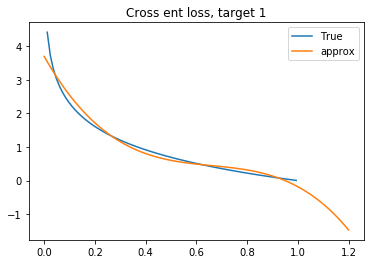

In [26]:
local_X = np.linspace(0, 1.2,100)
plt.plot(local_X, cross_ent(local_X, 1), label='True')
plt.plot(local_X,cross_ent_approx(local_X,theta.x, 1),label='approx')
plt.title("Cross ent loss, target 1")
plt.legend()

/home/apignet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/apignet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
/home/apignet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


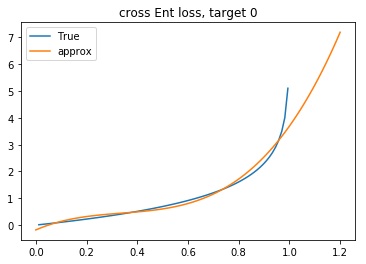

In [28]:
local_X = np.linspace(0, 1.2,100)
plt.plot(local_X, cross_ent(local_X, 0), label='True')
plt.plot(local_X,cross_ent_approx(local_X,theta.x, 0),label='approx')
plt.title("cross Ent loss, target 0")
plt.legend()